In [27]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)
plt.rcParams["figure.figsize"]=16,6

# LGB Starter

Robado de https://www.kaggle.com/swimmy/optiver-lgb-with-optimized-params-feat

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Training fold 1
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461271	training's RMSPE: 0.213535	valid_1's rmse: 0.000470453	valid_1's RMSPE: 0.216705
[200]	training's rmse: 0.000443067	training's RMSPE: 0.205108	valid_1's rmse: 0.00045474	valid_1's RMSPE: 0.209467
[300]	training's rmse: 0.000428577	training's RMSPE: 0.1984	valid_1's rmse: 0.00044356	valid_1's RMSPE: 0.204317
[400]	training's rmse: 0.000418038	training's RMSPE: 0.193521	valid_1's rmse: 0.000436744	valid_1's RMSPE: 0.201177
[500]	training's rmse: 0.000409555	training's RMSPE: 0.189594	valid_1's rmse: 0.00043173	valid_1's RMSPE: 0.198867
[600]	training's rmse: 0.000402852	training's RMSPE: 0.186491	valid_1's rmse: 0.000427853	valid_1's RMSPE: 0.197081
[700]	training's rmse: 0.000397197	training's RMSPE: 0.183873	valid_1's rmse: 0.000425296	valid_1's RMSPE: 0.195904
[800]	training's rmse: 0.000391722	training's RMSPE: 0.181339	valid_1's rmse: 0.000423511	valid_1's RMSPE: 0.195082

<Figure size 864x432 with 0 Axes>

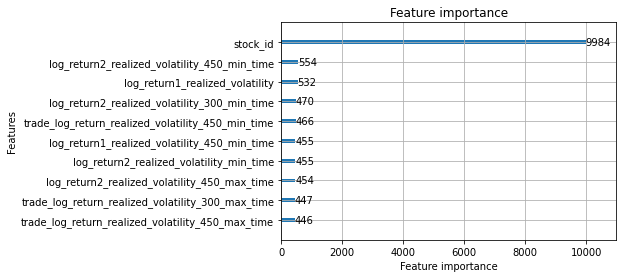

Training fold 2
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460573	training's RMSPE: 0.213117	valid_1's rmse: 0.000483337	valid_1's RMSPE: 0.224535
[200]	training's rmse: 0.000442196	training's RMSPE: 0.204614	valid_1's rmse: 0.000472868	valid_1's RMSPE: 0.219672
[300]	training's rmse: 0.000428636	training's RMSPE: 0.198339	valid_1's rmse: 0.000464905	valid_1's RMSPE: 0.215973
[400]	training's rmse: 0.000419251	training's RMSPE: 0.193996	valid_1's rmse: 0.000460738	valid_1's RMSPE: 0.214037
[500]	training's rmse: 0.000410443	training's RMSPE: 0.189921	valid_1's rmse: 0.00045503	valid_1's RMSPE: 0.211385
[600]	training's rmse: 0.000403068	training's RMSPE: 0.186508	valid_1's rmse: 0.000451693	valid_1's RMSPE: 0.209835
[700]	training's rmse: 0.000397063	training's RMSPE: 0.183729	valid_1's rmse: 0.000449325	valid_1's RMSPE: 0.208735
[800]	training's rmse: 0.000391971	training's RMSPE: 0.181373	valid_1's rmse: 0.000448699	valid_1's RMSPE: 0.20

<Figure size 864x432 with 0 Axes>

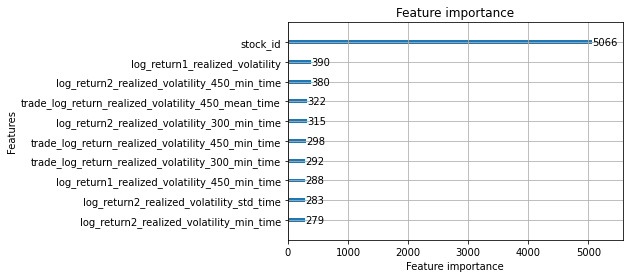

Training fold 3
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461374	training's RMSPE: 0.213541	valid_1's rmse: 0.0004642	valid_1's RMSPE: 0.214616
[200]	training's rmse: 0.000441358	training's RMSPE: 0.204277	valid_1's rmse: 0.000448088	valid_1's RMSPE: 0.207167
[300]	training's rmse: 0.00042901	training's RMSPE: 0.198562	valid_1's rmse: 0.000439353	valid_1's RMSPE: 0.203129
[400]	training's rmse: 0.000418372	training's RMSPE: 0.193638	valid_1's rmse: 0.000432315	valid_1's RMSPE: 0.199875
[500]	training's rmse: 0.000410262	training's RMSPE: 0.189885	valid_1's rmse: 0.000427352	valid_1's RMSPE: 0.19758
[600]	training's rmse: 0.000402435	training's RMSPE: 0.186262	valid_1's rmse: 0.000422912	valid_1's RMSPE: 0.195527
[700]	training's rmse: 0.000396882	training's RMSPE: 0.183692	valid_1's rmse: 0.00041994	valid_1's RMSPE: 0.194153
[800]	training's rmse: 0.000391894	training's RMSPE: 0.181383	valid_1's rmse: 0.000417762	valid_1's RMSPE: 0.193146

<Figure size 864x432 with 0 Axes>

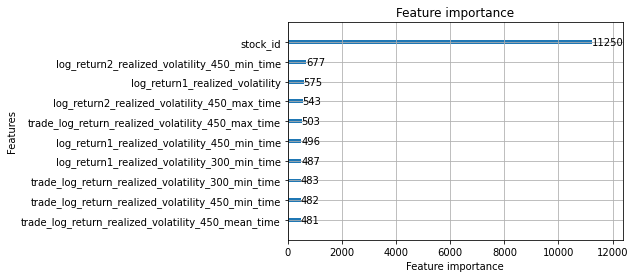

Training fold 4
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460759	training's RMSPE: 0.213288	valid_1's rmse: 0.000474667	valid_1's RMSPE: 0.218847
[200]	training's rmse: 0.000441485	training's RMSPE: 0.204366	valid_1's rmse: 0.000459681	valid_1's RMSPE: 0.211938
[300]	training's rmse: 0.000428146	training's RMSPE: 0.198191	valid_1's rmse: 0.00044961	valid_1's RMSPE: 0.207294
[400]	training's rmse: 0.000418291	training's RMSPE: 0.193629	valid_1's rmse: 0.00044274	valid_1's RMSPE: 0.204127
[500]	training's rmse: 0.000410128	training's RMSPE: 0.18985	valid_1's rmse: 0.000437457	valid_1's RMSPE: 0.201691
[600]	training's rmse: 0.000402408	training's RMSPE: 0.186277	valid_1's rmse: 0.00043292	valid_1's RMSPE: 0.1996
[700]	training's rmse: 0.000396394	training's RMSPE: 0.183493	valid_1's rmse: 0.000430047	valid_1's RMSPE: 0.198275
[800]	training's rmse: 0.000391395	training's RMSPE: 0.181179	valid_1's rmse: 0.000428359	valid_1's RMSPE: 0.197497


<Figure size 864x432 with 0 Axes>

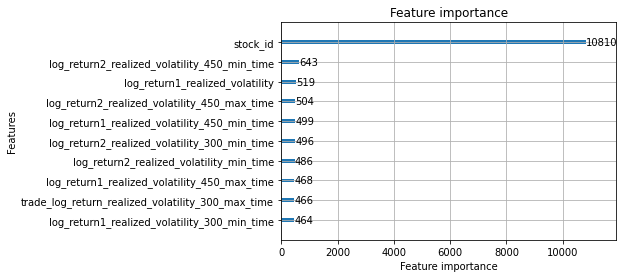

Training fold 5
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461241	training's RMSPE: 0.213393	valid_1's rmse: 0.000523422	valid_1's RMSPE: 0.243854
[200]	training's rmse: 0.000442011	training's RMSPE: 0.204497	valid_1's rmse: 0.000506858	valid_1's RMSPE: 0.236138
[300]	training's rmse: 0.000428336	training's RMSPE: 0.19817	valid_1's rmse: 0.000498391	valid_1's RMSPE: 0.232193
[400]	training's rmse: 0.000417902	training's RMSPE: 0.193343	valid_1's rmse: 0.00049406	valid_1's RMSPE: 0.230175
[500]	training's rmse: 0.000409791	training's RMSPE: 0.18959	valid_1's rmse: 0.000490495	valid_1's RMSPE: 0.228514
[600]	training's rmse: 0.000402558	training's RMSPE: 0.186244	valid_1's rmse: 0.000486175	valid_1's RMSPE: 0.226502
[700]	training's rmse: 0.000396779	training's RMSPE: 0.18357	valid_1's rmse: 0.000483463	valid_1's RMSPE: 0.225238
[800]	training's rmse: 0.000391759	training's RMSPE: 0.181248	valid_1's rmse: 0.000480407	valid_1's RMSPE: 0.22381

<Figure size 864x432 with 0 Axes>

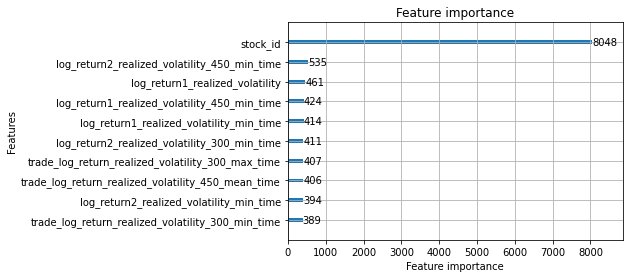

Training fold 6
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460902	training's RMSPE: 0.213123	valid_1's rmse: 0.00045891	valid_1's RMSPE: 0.215915
[200]	training's rmse: 0.000442059	training's RMSPE: 0.20441	valid_1's rmse: 0.000445674	valid_1's RMSPE: 0.209687
[300]	training's rmse: 0.000428301	training's RMSPE: 0.198049	valid_1's rmse: 0.000436211	valid_1's RMSPE: 0.205235
[400]	training's rmse: 0.000418099	training's RMSPE: 0.193331	valid_1's rmse: 0.000430363	valid_1's RMSPE: 0.202484
[500]	training's rmse: 0.000410167	training's RMSPE: 0.189663	valid_1's rmse: 0.000425828	valid_1's RMSPE: 0.20035
[600]	training's rmse: 0.000403511	training's RMSPE: 0.186585	valid_1's rmse: 0.000422165	valid_1's RMSPE: 0.198627
[700]	training's rmse: 0.000397777	training's RMSPE: 0.183934	valid_1's rmse: 0.000419779	valid_1's RMSPE: 0.197504
[800]	training's rmse: 0.000392299	training's RMSPE: 0.181401	valid_1's rmse: 0.000418067	valid_1's RMSPE: 0.1966

<Figure size 864x432 with 0 Axes>

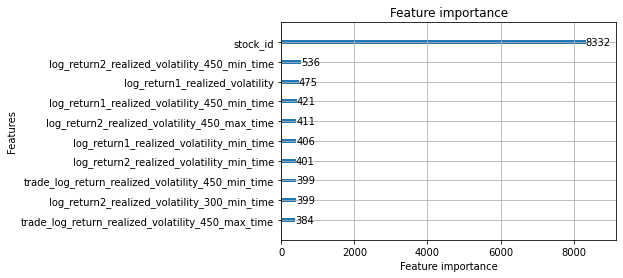

Training fold 7
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460711	training's RMSPE: 0.213312	valid_1's rmse: 0.000475078	valid_1's RMSPE: 0.218108
[200]	training's rmse: 0.000441658	training's RMSPE: 0.204491	valid_1's rmse: 0.000460646	valid_1's RMSPE: 0.211482
[300]	training's rmse: 0.000428282	training's RMSPE: 0.198298	valid_1's rmse: 0.000450957	valid_1's RMSPE: 0.207034
[400]	training's rmse: 0.000418005	training's RMSPE: 0.193539	valid_1's rmse: 0.000443533	valid_1's RMSPE: 0.203625
[500]	training's rmse: 0.000409563	training's RMSPE: 0.189631	valid_1's rmse: 0.00043783	valid_1's RMSPE: 0.201007
[600]	training's rmse: 0.000402493	training's RMSPE: 0.186357	valid_1's rmse: 0.000433896	valid_1's RMSPE: 0.199201
[700]	training's rmse: 0.000396651	training's RMSPE: 0.183652	valid_1's rmse: 0.000430671	valid_1's RMSPE: 0.19772
[800]	training's rmse: 0.00039129	training's RMSPE: 0.18117	valid_1's rmse: 0.000427892	valid_1's RMSPE: 0.19644

<Figure size 864x432 with 0 Axes>

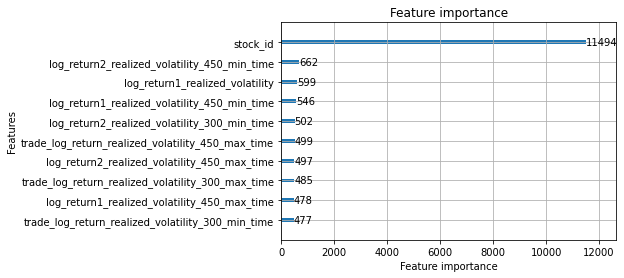

Training fold 8
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461881	training's RMSPE: 0.213815	valid_1's rmse: 0.000465088	valid_1's RMSPE: 0.214267
[200]	training's rmse: 0.000441574	training's RMSPE: 0.204415	valid_1's rmse: 0.000449968	valid_1's RMSPE: 0.207301
[300]	training's rmse: 0.000428677	training's RMSPE: 0.198445	valid_1's rmse: 0.000441561	valid_1's RMSPE: 0.203428
[400]	training's rmse: 0.000418464	training's RMSPE: 0.193717	valid_1's rmse: 0.000435123	valid_1's RMSPE: 0.200462
[500]	training's rmse: 0.00040966	training's RMSPE: 0.189641	valid_1's rmse: 0.000430616	valid_1's RMSPE: 0.198385
[600]	training's rmse: 0.000402648	training's RMSPE: 0.186395	valid_1's rmse: 0.000427016	valid_1's RMSPE: 0.196727
[700]	training's rmse: 0.000396577	training's RMSPE: 0.183585	valid_1's rmse: 0.000424723	valid_1's RMSPE: 0.19567
[800]	training's rmse: 0.000391674	training's RMSPE: 0.181315	valid_1's rmse: 0.00042343	valid_1's RMSPE: 0.1950

<Figure size 864x432 with 0 Axes>

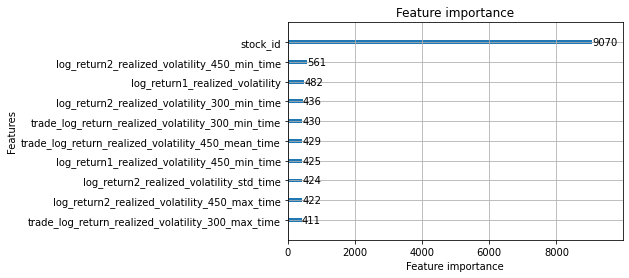

Training fold 9
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460748	training's RMSPE: 0.213277	valid_1's rmse: 0.000470036	valid_1's RMSPE: 0.216822
[200]	training's rmse: 0.0004406	training's RMSPE: 0.20395	valid_1's rmse: 0.000454869	valid_1's RMSPE: 0.209826
[300]	training's rmse: 0.000427307	training's RMSPE: 0.197798	valid_1's rmse: 0.00044482	valid_1's RMSPE: 0.20519
[400]	training's rmse: 0.000416903	training's RMSPE: 0.192982	valid_1's rmse: 0.000437764	valid_1's RMSPE: 0.201935
[500]	training's rmse: 0.000408916	training's RMSPE: 0.189284	valid_1's rmse: 0.000433033	valid_1's RMSPE: 0.199753
[600]	training's rmse: 0.000402242	training's RMSPE: 0.186195	valid_1's rmse: 0.000429244	valid_1's RMSPE: 0.198005
[700]	training's rmse: 0.000396196	training's RMSPE: 0.183396	valid_1's rmse: 0.000426256	valid_1's RMSPE: 0.196627
[800]	training's rmse: 0.000391254	training's RMSPE: 0.181108	valid_1's rmse: 0.000424344	valid_1's RMSPE: 0.195745

<Figure size 864x432 with 0 Axes>

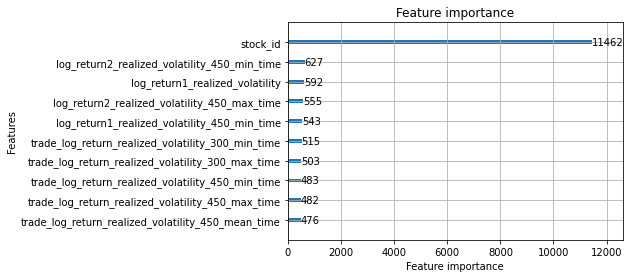

Training fold 10
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000463456	training's RMSPE: 0.214581	valid_1's rmse: 0.000474984	valid_1's RMSPE: 0.218116
[200]	training's rmse: 0.000443261	training's RMSPE: 0.205231	valid_1's rmse: 0.000458958	valid_1's RMSPE: 0.210757
[300]	training's rmse: 0.000428652	training's RMSPE: 0.198467	valid_1's rmse: 0.000447405	valid_1's RMSPE: 0.205452
[400]	training's rmse: 0.0004195	training's RMSPE: 0.194229	valid_1's rmse: 0.000441767	valid_1's RMSPE: 0.202863
[500]	training's rmse: 0.000410937	training's RMSPE: 0.190264	valid_1's rmse: 0.000436802	valid_1's RMSPE: 0.200583
[600]	training's rmse: 0.000404296	training's RMSPE: 0.18719	valid_1's rmse: 0.000433781	valid_1's RMSPE: 0.199196
[700]	training's rmse: 0.000398051	training's RMSPE: 0.184298	valid_1's rmse: 0.000430829	valid_1's RMSPE: 0.19784
[800]	training's rmse: 0.000391898	training's RMSPE: 0.181449	valid_1's rmse: 0.000427837	valid_1's RMSPE: 0.1964

<Figure size 864x432 with 0 Axes>

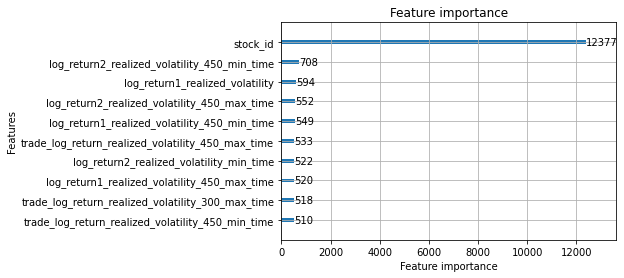

Training fold 11
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461636	training's RMSPE: 0.213602	valid_1's rmse: 0.000470694	valid_1's RMSPE: 0.218788
[200]	training's rmse: 0.000441796	training's RMSPE: 0.204422	valid_1's rmse: 0.000454763	valid_1's RMSPE: 0.211383
[300]	training's rmse: 0.00042835	training's RMSPE: 0.1982	valid_1's rmse: 0.000445675	valid_1's RMSPE: 0.207159
[400]	training's rmse: 0.000418276	training's RMSPE: 0.193539	valid_1's rmse: 0.000439253	valid_1's RMSPE: 0.204174
[500]	training's rmse: 0.000409378	training's RMSPE: 0.189422	valid_1's rmse: 0.000434371	valid_1's RMSPE: 0.201904
[600]	training's rmse: 0.000402583	training's RMSPE: 0.186278	valid_1's rmse: 0.000430781	valid_1's RMSPE: 0.200236
[700]	training's rmse: 0.000396422	training's RMSPE: 0.183427	valid_1's rmse: 0.000428107	valid_1's RMSPE: 0.198993
[800]	training's rmse: 0.000391249	training's RMSPE: 0.181033	valid_1's rmse: 0.000425889	valid_1's RMSPE: 0.197

<Figure size 864x432 with 0 Axes>

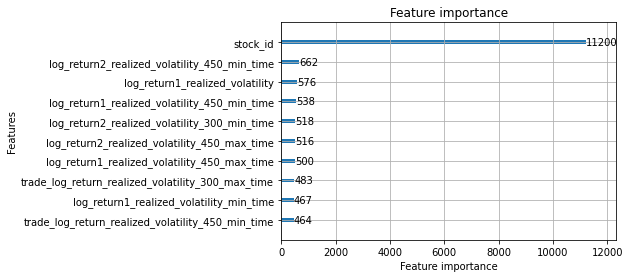

Training fold 12
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000462434	training's RMSPE: 0.214026	valid_1's rmse: 0.00047014	valid_1's RMSPE: 0.217472
[200]	training's rmse: 0.000442696	training's RMSPE: 0.204891	valid_1's rmse: 0.00045408	valid_1's RMSPE: 0.210043
[300]	training's rmse: 0.000428912	training's RMSPE: 0.198511	valid_1's rmse: 0.000443348	valid_1's RMSPE: 0.205079
[400]	training's rmse: 0.000418978	training's RMSPE: 0.193914	valid_1's rmse: 0.000436465	valid_1's RMSPE: 0.201895
[500]	training's rmse: 0.000410799	training's RMSPE: 0.190128	valid_1's rmse: 0.000431289	valid_1's RMSPE: 0.199501
[600]	training's rmse: 0.000403902	training's RMSPE: 0.186936	valid_1's rmse: 0.000427034	valid_1's RMSPE: 0.197533
[700]	training's rmse: 0.000398448	training's RMSPE: 0.184412	valid_1's rmse: 0.000424216	valid_1's RMSPE: 0.19623
[800]	training's rmse: 0.000392942	training's RMSPE: 0.181864	valid_1's rmse: 0.000421112	valid_1's RMSPE: 0.194

<Figure size 864x432 with 0 Axes>

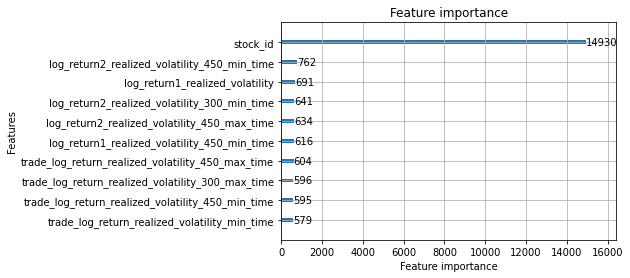

Training fold 13
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000462643	training's RMSPE: 0.213988	valid_1's rmse: 0.000468522	valid_1's RMSPE: 0.219299
[200]	training's rmse: 0.00044327	training's RMSPE: 0.205028	valid_1's rmse: 0.000455703	valid_1's RMSPE: 0.213299
[300]	training's rmse: 0.000429476	training's RMSPE: 0.198647	valid_1's rmse: 0.000447486	valid_1's RMSPE: 0.209453
[400]	training's rmse: 0.00041949	training's RMSPE: 0.194029	valid_1's rmse: 0.000442648	valid_1's RMSPE: 0.207188
[500]	training's rmse: 0.000410749	training's RMSPE: 0.189986	valid_1's rmse: 0.000439485	valid_1's RMSPE: 0.205708
[600]	training's rmse: 0.000403497	training's RMSPE: 0.186632	valid_1's rmse: 0.000436856	valid_1's RMSPE: 0.204477
[700]	training's rmse: 0.000397358	training's RMSPE: 0.183792	valid_1's rmse: 0.000435037	valid_1's RMSPE: 0.203626
[800]	training's rmse: 0.000391987	training's RMSPE: 0.181308	valid_1's rmse: 0.000433296	valid_1's RMSPE: 0.20

<Figure size 864x432 with 0 Axes>

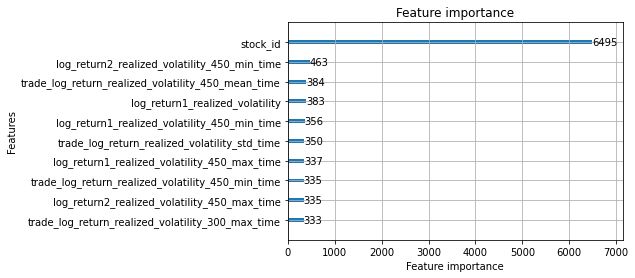

Training fold 14
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460766	training's RMSPE: 0.213285	valid_1's rmse: 0.000474662	valid_1's RMSPE: 0.218958
[200]	training's rmse: 0.000441316	training's RMSPE: 0.204282	valid_1's rmse: 0.000459484	valid_1's RMSPE: 0.211957
[300]	training's rmse: 0.000427544	training's RMSPE: 0.197907	valid_1's rmse: 0.000449663	valid_1's RMSPE: 0.207426
[400]	training's rmse: 0.000417444	training's RMSPE: 0.193232	valid_1's rmse: 0.000443278	valid_1's RMSPE: 0.204481
[500]	training's rmse: 0.00040864	training's RMSPE: 0.189156	valid_1's rmse: 0.000437497	valid_1's RMSPE: 0.201814
[600]	training's rmse: 0.000401935	training's RMSPE: 0.186053	valid_1's rmse: 0.00043388	valid_1's RMSPE: 0.200146
[700]	training's rmse: 0.000395916	training's RMSPE: 0.183267	valid_1's rmse: 0.000430787	valid_1's RMSPE: 0.198719
[800]	training's rmse: 0.000390826	training's RMSPE: 0.180911	valid_1's rmse: 0.000428679	valid_1's RMSPE: 0.19

<Figure size 864x432 with 0 Axes>

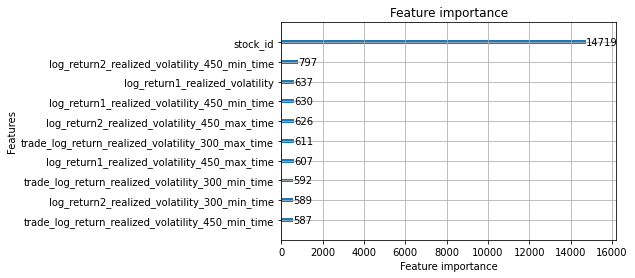

Training fold 15
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000462206	training's RMSPE: 0.213844	valid_1's rmse: 0.000466606	valid_1's RMSPE: 0.217309
[200]	training's rmse: 0.000442384	training's RMSPE: 0.204673	valid_1's rmse: 0.000450585	valid_1's RMSPE: 0.209847
[300]	training's rmse: 0.000429211	training's RMSPE: 0.198579	valid_1's rmse: 0.000441252	valid_1's RMSPE: 0.205501
[400]	training's rmse: 0.000418664	training's RMSPE: 0.193699	valid_1's rmse: 0.00043367	valid_1's RMSPE: 0.20197
[500]	training's rmse: 0.000409639	training's RMSPE: 0.189523	valid_1's rmse: 0.000428231	valid_1's RMSPE: 0.199437
[600]	training's rmse: 0.000403174	training's RMSPE: 0.186532	valid_1's rmse: 0.000424929	valid_1's RMSPE: 0.197899
[700]	training's rmse: 0.000397096	training's RMSPE: 0.18372	valid_1's rmse: 0.000421935	valid_1's RMSPE: 0.196504
[800]	training's rmse: 0.000391827	training's RMSPE: 0.181283	valid_1's rmse: 0.000419412	valid_1's RMSPE: 0.195

<Figure size 864x432 with 0 Axes>

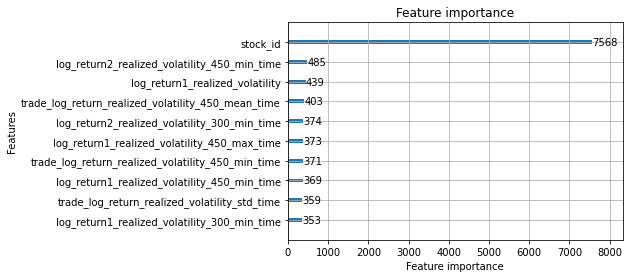

Training fold 16
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461182	training's RMSPE: 0.213378	valid_1's rmse: 0.000477847	valid_1's RMSPE: 0.222385
[200]	training's rmse: 0.000442277	training's RMSPE: 0.204631	valid_1's rmse: 0.000466305	valid_1's RMSPE: 0.217014
[300]	training's rmse: 0.000428947	training's RMSPE: 0.198464	valid_1's rmse: 0.000457013	valid_1's RMSPE: 0.21269
[400]	training's rmse: 0.000418246	training's RMSPE: 0.193512	valid_1's rmse: 0.000449417	valid_1's RMSPE: 0.209154
[500]	training's rmse: 0.00041069	training's RMSPE: 0.190017	valid_1's rmse: 0.000445598	valid_1's RMSPE: 0.207377
[600]	training's rmse: 0.000403589	training's RMSPE: 0.186731	valid_1's rmse: 0.00044194	valid_1's RMSPE: 0.205675
[700]	training's rmse: 0.000396964	training's RMSPE: 0.183666	valid_1's rmse: 0.000438542	valid_1's RMSPE: 0.204093
[800]	training's rmse: 0.000391882	training's RMSPE: 0.181315	valid_1's rmse: 0.000436482	valid_1's RMSPE: 0.203

<Figure size 864x432 with 0 Axes>

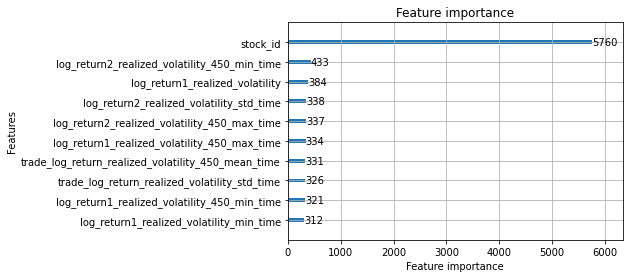

Training fold 17
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460017	training's RMSPE: 0.212888	valid_1's rmse: 0.000471462	valid_1's RMSPE: 0.218467
[200]	training's rmse: 0.000441777	training's RMSPE: 0.204447	valid_1's rmse: 0.000455453	valid_1's RMSPE: 0.211049
[300]	training's rmse: 0.00042952	training's RMSPE: 0.198774	valid_1's rmse: 0.000446709	valid_1's RMSPE: 0.206997
[400]	training's rmse: 0.00041884	training's RMSPE: 0.193832	valid_1's rmse: 0.000439477	valid_1's RMSPE: 0.203646
[500]	training's rmse: 0.000409707	training's RMSPE: 0.189605	valid_1's rmse: 0.000434923	valid_1's RMSPE: 0.201536
[600]	training's rmse: 0.000403042	training's RMSPE: 0.186521	valid_1's rmse: 0.000430688	valid_1's RMSPE: 0.199573
[700]	training's rmse: 0.000396971	training's RMSPE: 0.183711	valid_1's rmse: 0.000427094	valid_1's RMSPE: 0.197908
[800]	training's rmse: 0.000392027	training's RMSPE: 0.181423	valid_1's rmse: 0.000426243	valid_1's RMSPE: 0.19

<Figure size 864x432 with 0 Axes>

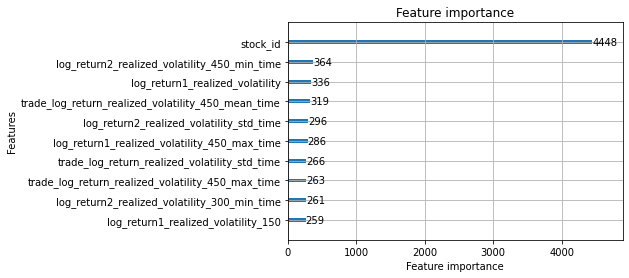

Training fold 18
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000459167	training's RMSPE: 0.212628	valid_1's rmse: 0.000482274	valid_1's RMSPE: 0.220809
[200]	training's rmse: 0.000440893	training's RMSPE: 0.204166	valid_1's rmse: 0.000467417	valid_1's RMSPE: 0.214007
[300]	training's rmse: 0.000427859	training's RMSPE: 0.19813	valid_1's rmse: 0.000458689	valid_1's RMSPE: 0.210011
[400]	training's rmse: 0.000418003	training's RMSPE: 0.193566	valid_1's rmse: 0.000451734	valid_1's RMSPE: 0.206827
[500]	training's rmse: 0.000409514	training's RMSPE: 0.189635	valid_1's rmse: 0.000446803	valid_1's RMSPE: 0.204569
[600]	training's rmse: 0.000402312	training's RMSPE: 0.1863	valid_1's rmse: 0.000442481	valid_1's RMSPE: 0.20259
[700]	training's rmse: 0.000396387	training's RMSPE: 0.183556	valid_1's rmse: 0.000439438	valid_1's RMSPE: 0.201197
[800]	training's rmse: 0.000391239	training's RMSPE: 0.181172	valid_1's rmse: 0.000437831	valid_1's RMSPE: 0.2004

<Figure size 864x432 with 0 Axes>

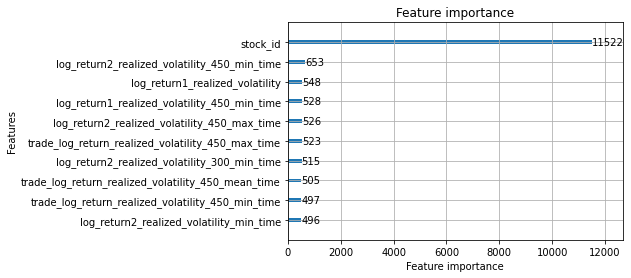

Training fold 19
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000460723	training's RMSPE: 0.213179	valid_1's rmse: 0.000471131	valid_1's RMSPE: 0.219004
[200]	training's rmse: 0.000441335	training's RMSPE: 0.204208	valid_1's rmse: 0.000457719	valid_1's RMSPE: 0.21277
[300]	training's rmse: 0.000427942	training's RMSPE: 0.198011	valid_1's rmse: 0.000448691	valid_1's RMSPE: 0.208573
[400]	training's rmse: 0.000417607	training's RMSPE: 0.193229	valid_1's rmse: 0.000442654	valid_1's RMSPE: 0.205767
[500]	training's rmse: 0.000410027	training's RMSPE: 0.189722	valid_1's rmse: 0.000438876	valid_1's RMSPE: 0.20401
[600]	training's rmse: 0.000403871	training's RMSPE: 0.186873	valid_1's rmse: 0.000439746	valid_1's RMSPE: 0.204415
[700]	training's rmse: 0.000397588	training's RMSPE: 0.183966	valid_1's rmse: 0.000437702	valid_1's RMSPE: 0.203465
[800]	training's rmse: 0.000391719	training's RMSPE: 0.181251	valid_1's rmse: 0.00043605	valid_1's RMSPE: 0.202

<Figure size 864x432 with 0 Axes>

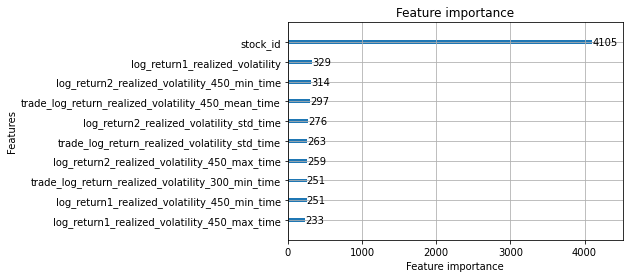

Training fold 20
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 0.000461294	training's RMSPE: 0.213637	valid_1's rmse: 0.000471575	valid_1's RMSPE: 0.215425
[200]	training's rmse: 0.000441799	training's RMSPE: 0.204609	valid_1's rmse: 0.000455956	valid_1's RMSPE: 0.20829
[300]	training's rmse: 0.000428708	training's RMSPE: 0.198546	valid_1's rmse: 0.000446525	valid_1's RMSPE: 0.203982
[400]	training's rmse: 0.000418148	training's RMSPE: 0.193655	valid_1's rmse: 0.000439011	valid_1's RMSPE: 0.200549
[500]	training's rmse: 0.000410059	training's RMSPE: 0.189909	valid_1's rmse: 0.0004344	valid_1's RMSPE: 0.198443
[600]	training's rmse: 0.000403029	training's RMSPE: 0.186653	valid_1's rmse: 0.000430633	valid_1's RMSPE: 0.196722
[700]	training's rmse: 0.00039718	training's RMSPE: 0.183944	valid_1's rmse: 0.000427964	valid_1's RMSPE: 0.195503
[800]	training's rmse: 0.000391844	training's RMSPE: 0.181473	valid_1's rmse: 0.000426036	valid_1's RMSPE: 0.1946

<Figure size 864x432 with 0 Axes>

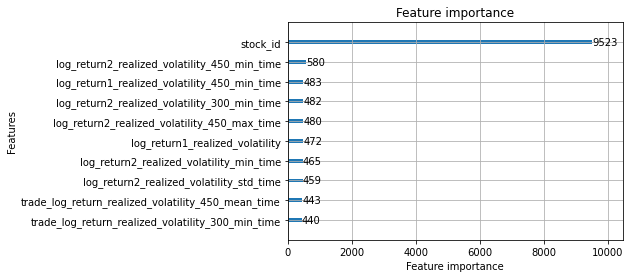

Our out of folds RMSPE is 0.1954707624494805


In [8]:
# data directory
data_dir = 'data/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv(data_dir + 'train.csv')
    test = pd.read_csv(data_dir + 'test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature

    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']
#     vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility',
#                 'log_return1_realized_volatility_600', 'log_return2_realized_volatility_600', 
#                 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400',
# #                 'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 
#                 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200',
# #                 'log_return1_realized_volatility_100', 'log_return2_realized_volatility_100', 
#                 'trade_log_return_realized_volatility',
#                 'trade_log_return_realized_volatility_600', 
#                 'trade_log_return_realized_volatility_400',
# #                 'trade_log_return_realized_volatility_300',
# #                 'trade_log_return_realized_volatility_100',
#                 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp

    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 1000,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 5,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    x_test = test.drop(['row_id', 'time_id'], axis = 1)
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 20, random_state = 1111, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 6000, 
                          early_stopping_rounds = 300, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        plt.figure(figsize=(12,6))
        lgb.plot_importance(model, max_num_features=10)
        plt.title("Feature importance")
        plt.show()
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 20
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return test_predictions

# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Traing and evaluate
test_predictions = train_and_evaluate(train, test)
# Save test predictions
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)

# Tratando de entender los datos

In [10]:
train_

,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread2_sum_450,price_spread2_mean_450,price_spread2_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,bid_ask_spread_sum_450,bid_ask_spread_mean_450,bid_ask_spread_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread2_sum_300,price_spread2_mean_300,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,price_spread2_sum_150,price_spread2_mean_150,price_spread2_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,bid_ask_spread_sum_150,bid_ask_spread_mean_150,bid_ask_spread_std_150,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150
0,303.125061,1.003725,0.000693,303.105539,1.003661,0.000781,0.002292,0.004499,7.613599e-06,0.000260,0.002325,0.006999,0.000008,0.000404,0.117051,0.000388,0.000295,0.257255,0.000852,0.000211,0.355451,0.001177,0.000213,0.053006,0.000176,0.000162,-0.045557,-0.000151,0.000126,97696,323.496689,138.101214,40738,134.894040,107.260583,0.098563,0.000326,0.000222,68.236749,1.003482,0.000514,68.231672,1.003407,0.000640,-0.000361,0.001721,-0.000005,0.000210,0.000068,0.004114,0.000001,0.0

In [11]:
train

,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread2_sum_450,price_spread2_mean_450,price_spread2_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,bid_ask_spread_sum_450,bid_ask_spread_mean_450,bid_ask_spread_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread2_sum_300,price_spread2_mean_300,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,price_spread2_sum_150,price_spread2_mean_150,price_spread2_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,bid_ask_spread_sum_150,bid_ask_spread_mean_150,bid_ask_spread_std_150,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_vola

In [12]:
pd.read_csv(data_dir + 'train.csv')

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [228]:
book_example = pd.read_parquet(data_dir + 'book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet(data_dir + 'trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==11]
trade_example = trade_example[trade_example['time_id']==11]

In [229]:
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

In [230]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap
302,11,0,0.999473,1.000176,0.999423,1.000376,205,100,20,30,0.999945
303,11,3,0.999473,1.000176,0.999423,1.000376,200,100,20,30,0.999941
304,11,13,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042
305,11,18,0.999473,1.000025,0.999423,1.000376,200,100,20,30,0.999841
306,11,28,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042
...,...,...,...,...,...,...,...,...,...,...,...
497,11,570,1.000025,1.000778,0.999975,1.000878,309,10,120,44,1.000754
498,11,574,1.000025,1.000778,0.999975,1.000878,200,10,120,44,1.000742
499,11,584,1.000276,1.000778,0.999975,1.000878,1,32,120,84,1.000291
500,11,585,1.000276,1.000778,0.999975,1.000878,1,32,120,44,1.000291


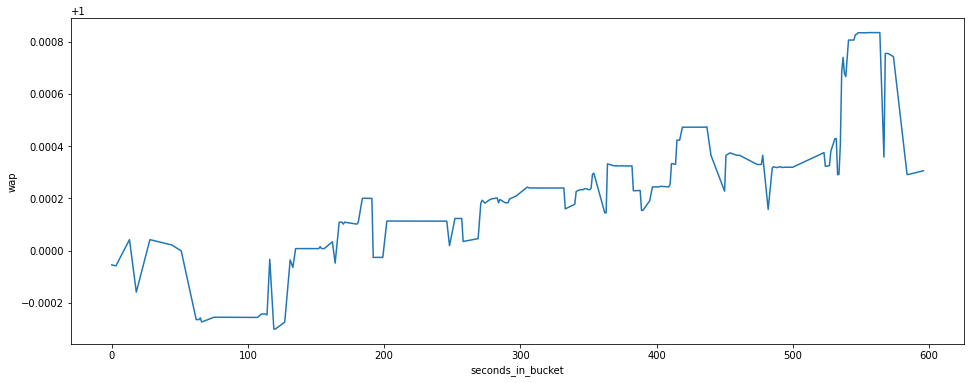

In [231]:
sns.lineplot(data=book_example, x="seconds_in_bucket", y="wap");

In [232]:
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
#book_example.loc[:,'log_return'] = log_return(book_example['bid_price1']).astype("float64")
book_example.loc[:,'time_diff'] = book_example['seconds_in_bucket'].diff()
book_example = book_example[~book_example['log_return'].isnull()]

In [233]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,log_return,time_diff
303,11,3,0.999473,1.000176,0.999423,1.000376,200,100,20,30,0.999941,-0.000004,3.0
304,11,13,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042,0.000100,10.0
305,11,18,0.999473,1.000025,0.999423,1.000376,200,100,20,30,0.999841,-0.000201,5.0
306,11,28,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042,0.000201,10.0
307,11,44,0.999473,1.000326,0.999423,1.000376,200,111,20,30,1.000022,-0.000020,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,11,570,1.000025,1.000778,0.999975,1.000878,309,10,120,44,1.000754,0.000000,2.0
498,11,574,1.000025,1.000778,0.999975,1.000878,200,10,120,44,1.000742,-0.000012,4.0
499,11,584,1.000276,1.000778,0.999975,1.000878,1,32,120,84,1.000291,-0.000451,10.0
500,11,585,1.000276,1.000778,0.999975,1.000878,1,32,120,44,1.000291,0.000000,1.0


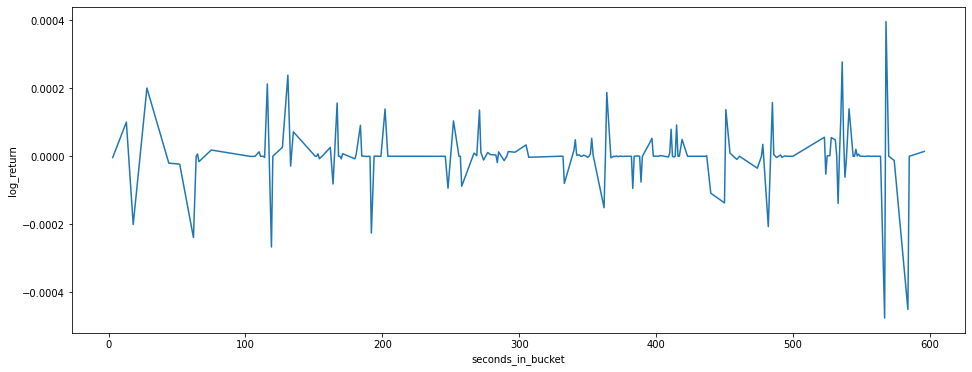

In [234]:
sns.lineplot(data=book_example, x="seconds_in_bucket", y="log_return");

In [235]:
realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

Realized volatility for stock_id 0 on time_id 5 is 0.0012044312600105803


In [236]:
trade_example

,time_id,seconds_in_bucket,price,size,order_count
40,11,0,0.999824,2,2
41,11,18,0.999925,1,1
42,11,28,0.999925,1,1
43,11,64,0.999724,1,1
44,11,75,1.000025,110,2
45,11,131,0.999925,1,1
46,11,164,0.999990,29,3
47,11,184,0.999875,20,1
48,11,202,0.999975,2,2
49,11,246,0.999724,3,1


In [208]:
test

,stock_id,time_id,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread2_sum_450,price_spread2_mean_450,price_spread2_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,bid_ask_spread_sum_450,bid_ask_spread_mean_450,bid_ask_spread_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread2_sum_300,price_spread2_mean_300,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,price_spread2_sum_150,price_spread2_mean_150,price_spread2_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,bid_ask_spread_sum_150,bid_ask_spread_mean_150,bid_ask_spread_std_150,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_volatility_

# Estimando volatilidad siguiendo un movimiento browniano 

Robado de https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities#Understanding-the-Resps-times,-and-getting-volatilities-for-free

In [237]:
import torch
device = torch.device('cuda')

# initialize parameters

# initialize the sigmas randomly
sigma = torch.tensor(np.random.randn(1)*.01 + 1, device=device, dtype=torch.float)

# the actual parameters are the logarithms of the delta T and sigma, to enforce positivity and have
# more stable convergence
with torch.no_grad():
    sigma_log = torch.log(sigma).clone().requires_grad_(True)

# load the data to gpu (increments)
dW = torch.tensor(book_example.log_return.values, device=device)
dT = torch.tensor(book_example.time_diff.values, device=device)

In [238]:
ITERS = 20000

# use Adam as it finds the right learning rates easily
opt = torch.optim.Adam([sigma_log])

iteration = 0
while iteration < ITERS:
    # reset the gradients to 0
    opt.zero_grad()

    # compute the log-likelihood (divided by number of rows)
    logL = torch.sum(1/2 *(dW**2  @ (1/dT)) * (1/torch.exp(2*sigma_log)) + 1/2*torch.sum(torch.log(dT)) + 4*sigma_log)
   
    # compute the gradient
    logL.backward()

    if iteration % 1000 == 0:
        with torch.no_grad():
            print(f'iter {iteration:8} {logL:.15} sigma_log.grad.norm {torch.norm(sigma_log.grad):.9} sigma_log.grad.norm {torch.squeeze(sigma_log,0):.9}')

    # execute one step of gradient descent
    opt.step()
    
    iteration+=1

iter        0 67.6277618408203 sigma_log.grad.norm 3.99999928 sigma_log.grad.norm -0.00327897631
iter     1000 63.6277961730957 sigma_log.grad.norm 3.99999475 sigma_log.grad.norm -1.00326979
iter     2000 59.6276359558105 sigma_log.grad.norm 3.99996185 sigma_log.grad.norm -2.00331616
iter     3000 55.6280403137207 sigma_log.grad.norm 3.99971795 sigma_log.grad.norm -3.00324368
iter     4000 51.6295204162598 sigma_log.grad.norm 3.99791646 sigma_log.grad.norm -4.0031004
iter     5000 47.6405563354492 sigma_log.grad.norm 3.98463798 sigma_log.grad.norm -5.00200129
iter     6000 43.7203750610352 sigma_log.grad.norm 3.88827062 sigma_log.grad.norm -5.99409056
iter     7000 40.2587814331055 sigma_log.grad.norm 3.26245117 sigma_log.grad.norm -6.93771696
iter     8000 38.6096572875977 sigma_log.grad.norm 1.14068961 sigma_log.grad.norm -7.61521864
iter     9000 38.508674621582 sigma_log.grad.norm 0.0400373936 sigma_log.grad.norm -7.77804565
iter    10000 38.5085754394531 sigma_log.grad.norm 0.0002

In [239]:
# let's bring stuff to CPU memory
sigma = torch.exp(sigma_log).detach().cpu().numpy()

In [240]:
sigma

array([0.00041673], dtype=float32)